# Simulating strategies in Hidden Markov Urn Experiment

### Vickie Wang

### Spring 2021

To Do:
* Add confidence to simulations
* Incorporate confidence into analyses
* Make prereg

We simulate a few different strategies for the Hidden Markov Urn experiment and examine the responses under the information bottleneck framework.

In [4]:
import pandas as pd
import numpy as np
from embo import EmpiricalBottleneck
import HMM_beads_utils as ut
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns
import os,ndd,pickle
from adjustText import adjust_text
cmap = plt.get_cmap("tab10")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Since everyone in the pilot saw the same sequence of 3000 beads, we use that sequence as the input for our simulated strategies as well.

In [184]:
adat=pd.read_csv('./data/A2AFC_raw.csv')
adat_trials = adat[0:3000]
#adat_h19 = adat[pd.notna(adat['Resp']) & (adat['H']!=.3)].copy() # Removing trials with no responses and with H in .01/.99

constant_table = adat_trials.loc[adat_trials['H'] != 0.3, ['X', 'Z', 'H', 'TSCP', 'TSCP2', 'Trial']].reset_index(drop=True)
#constant_table = constant_table[constant_table['H'] != 0.3]

constant_table['X'] = constant_table['X'] - 1
constant_table = constant_table.rename(columns={'X': 'Bead', 'Z': 'Jar'})
constant_table

,Bead,Jar,H,TSCP,TSCP2,Trial
0,0,0,0.01,1,0,1
1,0,0,0.01,2,1,2
2,0,0,0.01,3,2,3
3,0,0,0.01,4,3-4,4
4,0,0,0.01,5,3-4,5
...,...,...,...,...,...,...
2395,1,1,0.01,35,8+,2996
2396,1,1,0.01,36,8+,2997
2397,1,1,0.01,37,8+,2998
2398,0,1,0.01,38,8+,2999


We also include some noise in our simulated strategies because even if people are following a deterministic rule, sometimes they accidentally choose the other option. Here we set it so 5% of their responses are the opposite of what's dictated by their rule.

In [185]:
n, p = 1, .95
np.random.seed(17)
noise = np.random.binomial(n, p, 2400)

In [186]:
def get_previous_n_beads(w, x = constant_table['Bead']):
    '''
    Function that gets history of viewed beads
    Input:
        - w: number of past beads in history
        - x: full sequence of beads
    Output:
        - history: array of strings of previous w beads
    '''
    #x = np.array([1,2,1,1,2,2,1,1,1,2,2,1,2])
    numtrials = x.shape[0]
    aux_base = 2**np.arange(w)
    x_padded = np.empty(numtrials+w)
    x_padded[:w] = 0
    x_padded[w:] = x
    history_bin = np.array([sum(aux_base * np.array(x_padded[i:(i + w)][::-1])) for i in np.arange(numtrials)])
    return [np.binary_repr(int(z),w+1) for z in history_bin]

numprevious = 3
history = get_previous_n_beads(numprevious)

In [187]:
def flip_binary(s, numback):
    mask = (1 << numback) - 1
    return np.binary_repr(~int(s,2) & mask,numback)

In [188]:
def make_guess_with_rule(rules, history):
    '''
    Function that outputs predictions using specified rules dictionary and sequence of past beads
    Input:
        - rules: dictionary of rules (ex. {'00': '1', '10': '0'}). Key strings must be same length. Value string is length 1.
        - history: array of strings of previous w beads
    Output:
        - prediction: dataframe with history, relevant history, and predictions of next bead color
    '''
    numback = len(list(rules.keys())[0])
    wlog_rules = list(rules.keys())

    for r in wlog_rules:
        newkey = flip_binary(r, numback)
        newvalue = flip_binary(rules[r],1)
        rules[newkey] = newvalue

    pred_table = pd.DataFrame(history, columns = ['History']) 
    pred_table['rel_hist'] = [h[-numback:] for h in history]
    pred_table['pred'] = [int(r) for r in pred_table['rel_hist'].map(rules)]
    pred_table.at[:numback-1, 'pred'] = -1
    return pred_table

In [189]:
def make_confid_with_rule(rules, history):
    '''
    Function that outputs confidences using specified rules dictionary and sequence of past beads
    Input:
        - rules: dictionary of rules (ex. {'00': '1', '10': '0'}). Key strings must be same length. Value string is length 1.
        - history: array of strings of previous w beads
    Output:
        - confidence: dataframe with history, relevant history, and confidences in prediction of next bead color
    '''
    numback = len(list(rules.keys())[0])
    wlog_rules = list(rules.keys())

    for r in wlog_rules:
        newkey = flip_binary(r, numback)
        newvalue = rules[r]
        rules[newkey] = newvalue

    confid_table = pd.DataFrame(history, columns = ['History']) 
    confid_table['rel_hist'] = [h[-numback:] for h in history]
    confid_table['confid'] = [int(r) for r in confid_table['rel_hist'].map(rules)]
    confid_table.at[:numback-1, 'confid'] = -1
    return confid_table

In [190]:
def make_guess_with_rulecombo(pred_low, pred_high, H):
    '''
    Function that outputs predictions using combination of two rules depending on hazard rate
    Input:
        - pred_low: prediction table for low hazard
        - pred_high: prediction table for high hazard
        - H: sequence of hazard rates
    Output:
        - prediction: dataframe with history, relevant history, and predictions of next bead color
    '''
    hybrid_pred_table = pd.DataFrame({'H': constant_table['H'], 
                                  'pred_low': pred_low['Resp'],
                                  'hist_low': pred_low['Rel_Hist'],
                                  'pred_high': pred_high['Resp'],
                                  'hist_high': pred_high['Rel_Hist']})
    hybrid_pred_table['pred'] = np.where(hybrid_pred_table['H'] == 0.01, hybrid_pred_table['pred_low'], hybrid_pred_table['pred_high'])
    hybrid_pred_table['rel_hist'] = np.where(hybrid_pred_table['H'] == 0.01, hybrid_pred_table['hist_low'], hybrid_pred_table['hist_high'])
    return hybrid_pred_table[['pred','rel_hist']]

The stragies we simulate include:
1. adat_sim_all0 (0-back): Constant prediction; always guess White/0
2. adat_sim_previous (1-back): Guess same as previous bead
3. adat_sim_previous_flipped (1-back): Guess opposite of previous bead
4. adat_sim_previous_refined (1-back): Guess same as previous bead during low hazard condition, opposite of previous bead in high hazard condition
5. twoback_A (2-back): WW -> B; BW -> W and symmetric for other two conditions
6. twoback_B (2-back): WW -> W; BW -> B and symmetric for other two conditions
7. threeback_A (3-back): WWW -> W; BWW -> W; WBW -> W; BBW -> B and symmetric for other four conditions
8. threeback_B (3-back): WWW -> W; BWW -> B; WBW -> B; BBW -> W and symmetric for other four conditions
9. threeback_C (3-back): WWW -> W; BWW -> B; WBW -> B; BBW -> B and symmetric for other four conditions
10. hybrid (3-back + 1-back): Use threeback_A for low hazard and adat_sim_previous_flipped for high hazard

In [191]:
# Constant prediction
adat_sim_all0 = constant_table.assign(Subject = "all_0", Rel_Hist = '', 
                                      Resp = 0, Noise = noise)
adat_sim_all0

# One-back
adat_sim_previous = constant_table.assign(Subject = "previous", Rel_Hist = [int(h[-1]) for h in history], 
                                          Resp = [int(h[-1]) for h in history], Noise = noise)
adat_sim_previous.at[0, 'Resp'] = -1
adat_sim_previous

adat_sim_previous_flipped = constant_table.assign(Subject = "previous_flipped", Rel_Hist = [int(h[-1]) for h in history],
                                                  Resp = [int(h[-1]) ^ 1 for h in history], Noise = noise)
adat_sim_previous_flipped.at[0, 'Resp'] = -1

adat_sim_previous_refined = constant_table.assign(Subject = "previous_refined", Rel_Hist = [int(h[-1]) for h in history],
                                                  Resp = [adat_sim_previous.at[i,'Resp'] if constant_table.at[i,'H'] == 0.01 
                                                                                         else adat_sim_previous_flipped.at[i,'Resp'] for i in np.arange(constant_table.shape[0])], Noise = noise)
adat_sim_previous_refined

# Two-back
twoback_A_rules = {'00': '1', '10': '0'}
twoback_A_pred_table = make_guess_with_rule(twoback_A_rules, history)
twoback_A = constant_table.assign(Subject = "twoback_A", Rel_Hist = twoback_A_pred_table['rel_hist'],
                                  Resp = twoback_A_pred_table['pred'], Noise = noise)
twoback_A

twoback_B_rules = {'00': '0', '10': '1'}
twoback_B_pred_table = make_guess_with_rule(twoback_B_rules, history)
twoback_B = constant_table.assign(Subject = "twoback_B", Rel_Hist = twoback_B_pred_table['rel_hist'],
                                  Resp = twoback_B_pred_table['pred'], Noise = noise)
twoback_B

# Three-back
threeback_A_rules = {'000': '0', '100': '0', '010': '0', '110': '1'}
threeback_A_pred_table = make_guess_with_rule(threeback_A_rules, history)
threeback_A = constant_table.assign(Subject = "threeback_A", Rel_Hist = threeback_A_pred_table['rel_hist'],
                                    Resp = threeback_A_pred_table['pred'], Noise = noise)
threeback_A

threeback_B_rules = {'000': '0', '100': '1', '010': '1', '110': '0'}
threeback_B_pred_table = make_guess_with_rule(threeback_B_rules, history)
threeback_B = constant_table.assign(Subject = "threeback_B", Rel_Hist = threeback_B_pred_table['rel_hist'],
                                    Resp = threeback_B_pred_table['pred'], Noise = noise)
threeback_B

threeback_C_rules = {'000': '0', '100': '1', '010': '1', '110': '1'}
threeback_C_pred_table = make_guess_with_rule(threeback_C_rules, history)
threeback_C = constant_table.assign(Subject = "threeback_C", Rel_Hist = threeback_C_pred_table['rel_hist'],
                                    Resp = threeback_C_pred_table['pred'], Noise = noise)
threeback_C

hybrid_pred_table = make_guess_with_rulecombo(threeback_A, adat_sim_previous_flipped, constant_table['H'])
hybrid = constant_table.assign(Subject = "hybrid", Rel_Hist = hybrid_pred_table['rel_hist'],
                                    Resp = hybrid_pred_table['pred'], Noise = noise)

threeback_A_confid_rules = {'000': '1', '100': '1', '010': '0', '110': '0'}
threeback_A_confid_table = make_confid_with_rule(threeback_A_confid_rules, history)
threeback_A_confid = constant_table.assign(Subject = ["threeback_A_high" if threeback_A_confid_table.at[i, 'confid'] == 1
                                                      else "threeback_A_low" for i in np.arange(constant_table.shape[0])], 
                                           Rel_Hist = threeback_A_pred_table['rel_hist'],
                                           Resp = threeback_A_pred_table['pred'], Noise = noise,
                                           Confidence = threeback_A_confid_table['confid'])

threeback_A_confid

,Bead,Jar,H,TSCP,TSCP2,Trial,Subject,Rel_Hist,Resp,Noise
0,0,0,0.01,1,0,1,all_0,,0,1
1,0,0,0.01,2,1,2,all_0,,0,1
2,0,0,0.01,3,2,3,all_0,,0,1
3,0,0,0.01,4,3-4,4,all_0,,0,1
4,0,0,0.01,5,3-4,5,all_0,,0,1
...,...,...,...,...,...,...,...,...,...,...
2395,1,1,0.01,35,8+,2996,all_0,,0,0
2396,1,1,0.01,36,8+,2997,all_0,,0,1
2397,1,1,0.01,37,8+,2998,all_0,,0,0
2398,0,1,0.01,38,8+,2999,all_0,,0,1


,Bead,Jar,H,TSCP,TSCP2,Trial,Subject,Rel_Hist,Resp,Noise
0,0,0,0.01,1,0,1,previous,0,-1,1
1,0,0,0.01,2,1,2,previous,1,1,1
2,0,0,0.01,3,2,3,previous,1,1,1
3,0,0,0.01,4,3-4,4,previous,1,1,1
4,0,0,0.01,5,3-4,5,previous,1,1,1
...,...,...,...,...,...,...,...,...,...,...
2395,1,1,0.01,35,8+,2996,previous,0,0,0
2396,1,1,0.01,36,8+,2997,previous,0,0,1
2397,1,1,0.01,37,8+,2998,previous,0,0,0
2398,0,1,0.01,38,8+,2999,previous,0,0,1


,Bead,Jar,H,TSCP,TSCP2,Trial,Subject,Rel_Hist,Resp,Noise
0,0,0,0.01,1,0,1,previous_refined,0,-1,1
1,0,0,0.01,2,1,2,previous_refined,1,1,1
2,0,0,0.01,3,2,3,previous_refined,1,1,1
3,0,0,0.01,4,3-4,4,previous_refined,1,1,1
4,0,0,0.01,5,3-4,5,previous_refined,1,1,1
...,...,...,...,...,...,...,...,...,...,...
2395,1,1,0.01,35,8+,2996,previous_refined,0,0,0
2396,1,1,0.01,36,8+,2997,previous_refined,0,0,1
2397,1,1,0.01,37,8+,2998,previous_refined,0,0,0
2398,0,1,0.01,38,8+,2999,previous_refined,0,0,1


,Bead,Jar,H,TSCP,TSCP2,Trial,Subject,Rel_Hist,Resp,Noise
0,0,0,0.01,1,0,1,twoback_A,00,-1,1
1,0,0,0.01,2,1,2,twoback_A,11,-1,1
2,0,0,0.01,3,2,3,twoback_A,01,1,1
3,0,0,0.01,4,3-4,4,twoback_A,01,1,1
4,0,0,0.01,5,3-4,5,twoback_A,01,1,1
...,...,...,...,...,...,...,...,...,...,...
2395,1,1,0.01,35,8+,2996,twoback_A,10,0,0
2396,1,1,0.01,36,8+,2997,twoback_A,00,1,1
2397,1,1,0.01,37,8+,2998,twoback_A,00,1,0
2398,0,1,0.01,38,8+,2999,twoback_A,00,1,1


,Bead,Jar,H,TSCP,TSCP2,Trial,Subject,Rel_Hist,Resp,Noise
0,0,0,0.01,1,0,1,twoback_B,00,-1,1
1,0,0,0.01,2,1,2,twoback_B,11,-1,1
2,0,0,0.01,3,2,3,twoback_B,01,0,1
3,0,0,0.01,4,3-4,4,twoback_B,01,0,1
4,0,0,0.01,5,3-4,5,twoback_B,01,0,1
...,...,...,...,...,...,...,...,...,...,...
2395,1,1,0.01,35,8+,2996,twoback_B,10,1,0
2396,1,1,0.01,36,8+,2997,twoback_B,00,0,1
2397,1,1,0.01,37,8+,2998,twoback_B,00,0,0
2398,0,1,0.01,38,8+,2999,twoback_B,00,0,1


,Bead,Jar,H,TSCP,TSCP2,Trial,Subject,Rel_Hist,Resp,Noise
0,0,0,0.01,1,0,1,threeback_A,000,-1,1
1,0,0,0.01,2,1,2,threeback_A,111,-1,1
2,0,0,0.01,3,2,3,threeback_A,101,-1,1
3,0,0,0.01,4,3-4,4,threeback_A,001,0,1
4,0,0,0.01,5,3-4,5,threeback_A,001,0,1
...,...,...,...,...,...,...,...,...,...,...
2395,1,1,0.01,35,8+,2996,threeback_A,110,1,0
2396,1,1,0.01,36,8+,2997,threeback_A,100,0,1
2397,1,1,0.01,37,8+,2998,threeback_A,000,0,0
2398,0,1,0.01,38,8+,2999,threeback_A,000,0,1


,Bead,Jar,H,TSCP,TSCP2,Trial,Subject,Rel_Hist,Resp,Noise
0,0,0,0.01,1,0,1,threeback_B,000,-1,1
1,0,0,0.01,2,1,2,threeback_B,111,-1,1
2,0,0,0.01,3,2,3,threeback_B,101,-1,1
3,0,0,0.01,4,3-4,4,threeback_B,001,1,1
4,0,0,0.01,5,3-4,5,threeback_B,001,1,1
...,...,...,...,...,...,...,...,...,...,...
2395,1,1,0.01,35,8+,2996,threeback_B,110,0,0
2396,1,1,0.01,36,8+,2997,threeback_B,100,1,1
2397,1,1,0.01,37,8+,2998,threeback_B,000,0,0
2398,0,1,0.01,38,8+,2999,threeback_B,000,0,1


,Bead,Jar,H,TSCP,TSCP2,Trial,Subject,Rel_Hist,Resp,Noise
0,0,0,0.01,1,0,1,threeback_C,000,-1,1
1,0,0,0.01,2,1,2,threeback_C,111,-1,1
2,0,0,0.01,3,2,3,threeback_C,101,-1,1
3,0,0,0.01,4,3-4,4,threeback_C,001,0,1
4,0,0,0.01,5,3-4,5,threeback_C,001,0,1
...,...,...,...,...,...,...,...,...,...,...
2395,1,1,0.01,35,8+,2996,threeback_C,110,1,0
2396,1,1,0.01,36,8+,2997,threeback_C,100,1,1
2397,1,1,0.01,37,8+,2998,threeback_C,000,0,0
2398,0,1,0.01,38,8+,2999,threeback_C,000,0,1


,Bead,Jar,H,TSCP,TSCP2,Trial,Subject,Rel_Hist,Resp,Noise,Confidence
0,0,0,0.01,1,0,1,threeback_A_low,000,-1,1,-1
1,0,0,0.01,2,1,2,threeback_A_low,111,-1,1,-1
2,0,0,0.01,3,2,3,threeback_A_low,101,-1,1,-1
3,0,0,0.01,4,3-4,4,threeback_A_low,001,0,1,0
4,0,0,0.01,5,3-4,5,threeback_A_low,001,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2395,1,1,0.01,35,8+,2996,threeback_A_low,110,1,0,0
2396,1,1,0.01,36,8+,2997,threeback_A_high,100,0,1,1
2397,1,1,0.01,37,8+,2998,threeback_A_high,000,0,0,1
2398,0,1,0.01,38,8+,2999,threeback_A_high,000,0,1,1


In [280]:
def gen_sim_pred(sname,beads,jars,p,h_array):
    '''
    Function to generate responses from the ideal observer with different internal estimates of p and h
    INPUT:
        - sname: subject identifier in data frame
        - beads: 1D array of observed bead sequence
        - jars: 1D array of jar sequence that generated beads
        - p: internal model estimate of the probability that the bead will match the generating jar
        - h_array: internal estimate of the hazard rate
    OUTPUT:
        -df: data frame with the following columns
            - Subject: subject ID + simulation type (from no noise to lots of noise)
            - Trial: trial number from start of experiment
            - Jar: jar generating the bead
            - Bead: bead observed on each trial
            - Prior: prior probability that the the jar generating the next bead = 1 (before observing the bead)
            - Posterior: posterior probability that the jar generating the last bead = 1 (after observing the bead)
            - Prediction: simulated prediction
    '''
    
    # Initialize
    p_jars = np.array([.5,.5])              # Initial prior
    likes = np.array([[p,(1-p)],[(1-p),p]]) # Likelihood
    prior = np.zeros(len(beads))            # Initialize trial-by-trial priors
    pred_hardmax = np.zeros(len(beads))     # Initialize hardmax predictions
    posterior = np.zeros(len(beads))        # Initialize trial-by-trial posteriors
    
    # Loop through all trials and get simulated responses
    for i in np.arange(len(beads)):
        # Apply hazard rate
        h = h_array[i]
        z1,z2 = tuple(p_jars.copy())
        p_jars = [(1-h)*z1 + h*z2, (1-h)*z2 + h*z1]

        #Save Prior
        prior[i] = p_jars[1]
        
        # Incorporate likelihood
        p_jars = p_jars*likes[int(beads[i])]
        p_jars = p_jars/sum(p_jars)
        
        # Save posterios
        posterior[i] = p_jars[1]
        
    # Get harmax predictions
    pred_hardmax[prior!=.5] = np.array(prior[prior!=.5] > .5).astype(int)
    pred_hardmax[prior==.5] = np.random.choice([0,1],size=len(prior[prior==.5]),replace=True)
    
    # Save data frame
    df = pd.DataFrame({
        'Subject':np.array([str(sname)+'_Hard']*len(beads)),
        'Trial':np.arange(1,len(beads)+1),
        'Jar':jars,
        'Bead':beads,
        'Prior':prior,
        'Posterior':posterior,
        'Prediction':pred_hardmax
    })
    
    '''
    # Add noisy responses - larger values == more deterministic (closer to hardmax)
    noises = [100,10,5,2,1,.5]  # Noise values from least to most noisy
    df_prime = df.copy()        # Initialize data frame
    for n in noises:
        noisy_prior,noisy_posterior,noisy_pred = add_noise(n,prior,posterior) # Add noise to ideal observer
        df2 = df_prime.copy()                                                 # Initialize second df (ugly)    
        df2['Prior'] = noisy_prior           # Save noisy prior                                       
        df2['Posterior'] = noisy_posterior   # Save noisy posterior
        df2['Prediction'] = noisy_pred       # Save noisy predictions based on above
        
        # Code to make up for my lack of generalizing skills
        if n >=1:
            df2['Subject'] = np.array([str(sname)+'_'+str(n)]*len(beads))
        else:
            df2['Subject'] = np.array([str(sname)+'_'+str(round(n,2))]*len(beads))
            
        # Append to data frame
        df = df.append(df2,ignore_index=True)
    '''
    return(df)

def add_noise(beta,prior,posterior):
    '''
    Helper function to add noise to simulated responses
    '''
    noisy_prior = 1/(1+np.exp(-beta*(prior-(1-prior))))
    noisy_posterior = 1/(1+np.exp(-beta*(posterior-(1-posterior))))
    return(noisy_prior,noisy_posterior,(np.random.uniform(size=len(prior))<noisy_prior).astype(int))

In [281]:
d = gen_sim_pred("Ideal",constant_table['Bead'],constant_table['Jar'],0.8,np.array(constant_table['H']))
d

d['Subject'].unique()
d_hard = d[d['Subject'] == "Ideal_Hard"].merge(adat_trials[adat_trials.columns.difference(d.columns)], left_index=True, right_index=True).rename(columns = {'Prediction': 'Resp'})
d_hard

,Subject,Trial,Jar,Bead,Prior,Posterior,Prediction
0,Ideal_Hard,1,0,0,0.500000,0.200000,0.0
1,Ideal_Hard,2,0,0,0.206000,0.060911,0.0
2,Ideal_Hard,3,0,0,0.069692,0.018384,0.0
3,Ideal_Hard,4,0,0,0.028016,0.007154,0.0
4,Ideal_Hard,5,0,0,0.017011,0.004308,0.0
...,...,...,...,...,...,...,...
16795,Ideal_0.5,2396,1,1,0.616291,0.620890,0.0
16796,Ideal_0.5,2397,1,1,0.618565,0.621475,0.0
16797,Ideal_0.5,2398,1,1,0.619139,0.621622,1.0
16798,Ideal_0.5,2399,1,0,0.619283,0.610195,0.0


array(['Ideal_Hard', 'Ideal_100', 'Ideal_10', 'Ideal_5', 'Ideal_2',
       'Ideal_1', 'Ideal_0.5'], dtype=object)

,Subject,Trial,Jar,Bead,Prior,Posterior,Resp,H,TSCP,TSCP2
0,Ideal_Hard,1,0,0,0.500000,0.200000,0.0,0.01,1,0
1,Ideal_Hard,2,0,0,0.206000,0.060911,0.0,0.01,2,1
2,Ideal_Hard,3,0,0,0.069692,0.018384,0.0,0.01,3,2
3,Ideal_Hard,4,0,0,0.028016,0.007154,0.0,0.01,4,3-4
4,Ideal_Hard,5,0,0,0.017011,0.004308,0.0,0.01,5,3-4
...,...,...,...,...,...,...,...,...,...,...
2395,Ideal_Hard,2396,1,1,0.973835,0.993328,1.0,0.01,35,8+
2396,Ideal_Hard,2397,1,1,0.983461,0.995813,1.0,0.01,36,8+
2397,Ideal_Hard,2398,1,1,0.985897,0.996437,1.0,0.01,37,8+
2398,Ideal_Hard,2399,1,0,0.986508,0.948131,1.0,0.01,38,8+


(array([1062.,   47.,   50.,   24.,   18.,   19.,   24.,   51.,   51.,
        1054.]),
 array([0.01328844, 0.11063075, 0.20797307, 0.30531538, 0.40265769,
        0.5       , 0.59734231, 0.69468462, 0.79202693, 0.88936925,
        0.98671156]),
 <BarContainer object of 10 artists>)

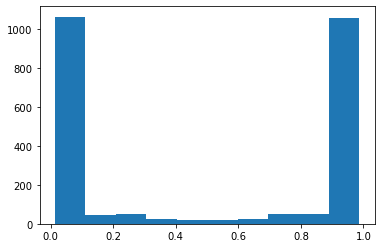

In [293]:
plt.hist(d_hard['Prior'])

In [282]:
adat_sim = pd.concat([adat_sim_all0, 
                      adat_sim_previous, 
                      adat_sim_previous_flipped, 
                      adat_sim_previous_refined,
                      twoback_A,
                      twoback_B,
                      threeback_A,
                      threeback_B,
                      threeback_C,
                      hybrid])
adat_sim = adat_sim[adat_sim['Resp'] != -1]
adat_sim['Resp'] = np.where(adat_sim['Resp']*1.0 == adat_sim['Noise'],1,0)
adat_sim = pd.concat([adat_sim, d_hard])

adat_sim['Correct'] = 1*(adat_sim['Jar'] == adat_sim['Resp'])

In [283]:
adat_sim

,Bead,Jar,H,TSCP,TSCP2,Trial,Subject,Rel_Hist,Resp,Noise,Prior,Posterior,Correct
0,0,0,0.01,1,0,1,all_0,,0.0,1.0,NaN,NaN,1
1,0,0,0.01,2,1,2,all_0,,0.0,1.0,NaN,NaN,1
2,0,0,0.01,3,2,3,all_0,,0.0,1.0,NaN,NaN,1
3,0,0,0.01,4,3-4,4,all_0,,0.0,1.0,NaN,NaN,1
4,0,0,0.01,5,3-4,5,all_0,,0.0,1.0,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,1,1,0.01,35,8+,2396,Ideal_Hard,NaN,1.0,NaN,0.973835,0.993328,1
2396,1,1,0.01,36,8+,2397,Ideal_Hard,NaN,1.0,NaN,0.983461,0.995813,1
2397,1,1,0.01,37,8+,2398,Ideal_Hard,NaN,1.0,NaN,0.985897,0.996437,1
2398,0,1,0.01,38,8+,2399,Ideal_Hard,NaN,1.0,NaN,0.986508,0.948131,1


We can check the accuracies, defined as whether the response matched the underlying jar, in the low and high hazard conditions as well as overall. Note that the directions for the participant are to guess the color of the next bead, not the jar the next bead will come from, but this definition of accuracy decreases the noise and should be almost equivalent.

In [284]:
# Get mean correct responses per subject
adat_corr_sim_p = adat_sim[['Subject','H','Correct']].groupby(['Subject','H'],as_index=False).mean()
adat_corr_sim_p

adat_sim[['Subject','Correct']].groupby(['Subject'],as_index=False).mean()

,Subject,H,Correct
0,Ideal_Hard,0.01,0.946667
1,Ideal_Hard,0.99,0.964444
2,all_0,0.01,0.508667
3,all_0,0.99,0.488889
4,hybrid,0.01,0.502338
5,hybrid,0.99,0.243333
6,previous,0.01,0.222815
7,previous,0.99,0.756667
8,previous_flipped,0.01,0.777185
9,previous_flipped,0.99,0.243333


,Subject,Correct
0,Ideal_Hard,0.953333
1,all_0,0.501250
2,hybrid,0.405090
3,previous,0.423093
4,previous_flipped,0.576907
5,previous_refined,0.230513
6,threeback_A,0.499374
7,threeback_B,0.418023
8,threeback_C,0.493951
9,twoback_A,0.494996


In [285]:
# Get responses since last source switch
adat_tscp_sim_p = adat_sim[['Subject','H','TSCP2','Correct']].groupby(['Subject','H','TSCP2'],as_index=False).mean()
print(adat_tscp_sim_p['H'].unique())

[0.01 0.99]


<Figure size 1080x432 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:xlabel='H', ylabel='Correct'>

<AxesSubplot:xlabel='H', ylabel='Correct'>

<AxesSubplot:xlabel='H', ylabel='Correct'>

(-0.05, 1.05)

(-0.5, 1.5)

Text(0, 0.5, 'Mean Correct Predictions')

Text(0.5, 0, 'Hazard Rate')

<AxesSubplot:>

<AxesSubplot:xlabel='TSCP2', ylabel='Correct'>

(0.0, 1.0)

Text(0, 0.5, 'Prop. Correct Predictions')

Text(0.5, 0, 'Trial Since Source Switch')

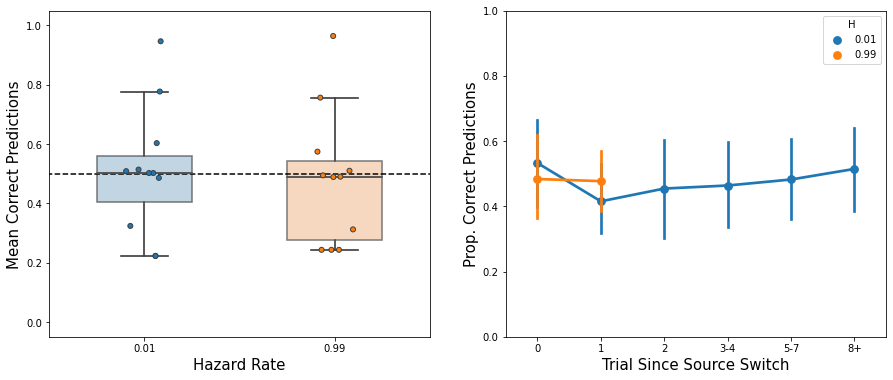

In [286]:
# Plot behavior
plt.figure(1,(15,6))
# Plot boxplots of proportion correct
plt.subplot(1,2,1)
plt.plot([-1,3],[.5,.5],'--k')
sns.boxplot(x = 'H',y='Correct',data=adat_corr_sim_p,dodge=True,fliersize=0,width=.5,color='white')
sns.boxplot(x = 'H',y='Correct',data=adat_corr_sim_p,dodge=True,fliersize=0,width=.5,boxprops=dict(alpha=.3))
sns.stripplot(x = 'H',y='Correct',data=adat_corr_sim_p,linewidth=1)
plt.ylim([-.05,1.05])
plt.xlim([-.5,1.5])
plt.ylabel('Mean Correct Predictions',size=15)
plt.xlabel('Hazard Rate',size=15)

# Plot proportion correct since last source switch
plt.subplot(1,2,2)
sns.pointplot(x='TSCP2',y='Correct',data=adat_tscp_sim_p,hue='H')
plt.ylim([0,1])
plt.ylabel('Prop. Correct Predictions',size=15)
plt.xlabel('Trial Since Source Switch',size=15)

<Figure size 576x432 with 0 Axes>

Text(0, 0.5, 'Mutual Information between\n$X_{past}$ and $X_{future}$')

Text(0.5, 0, 'Window size of $X$ into the past')

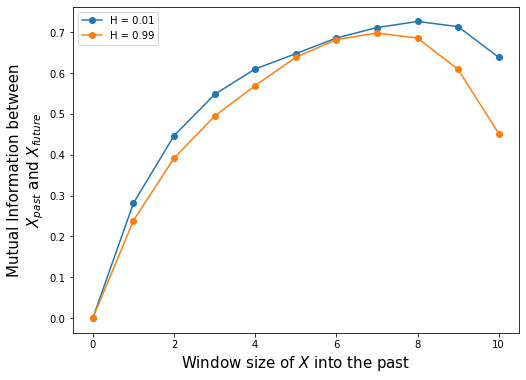

In [287]:
# Test bounds in each session
def get_windowed_mi(x,z,nw):
    '''
    Function that windows of observations from a sequence x offset from y and computes the MI
    Input:
        - x: sequence of "past" observations to be windowed
        - z: sequence that serves as the "future" events
        - nw: maximum window size
    Output:
        - mis: NSB estimated mutual informtion values for each window size
    '''
    mis = np.zeros(nw+1) #vector of mutual informations for different window sizes
    for w in np.arange(1,nw+1):
        xw,zw = ut.get_windowed_x(x,z,w=w)         # use convenience function from utilities to window x
        mis[w] = ut.mutual_inf_nsb(xw,zw,[2**w,2]) # use convenience function from utilities to compute NSB mutual info
    return(mis)

# Get all trials in all three sessions that match low and high hazard rates
nw = 10 #number of windows into the past we want to compute

#Since everyone saw the same sequence, we can speed this up by subselecting one example of all the trials the first subject saw
adat_trials = constant_table

# Computed windowed predictive information in the low hazard rate
adat_mis_h1 = get_windowed_mi(adat_trials['Bead'].loc[adat_trials['H'] == .01],
                              adat_trials['Jar'].loc[adat_trials['H'] == .01],nw)

# Computed windowed predictive information in the low hazard rate
adat_mis_h9 = get_windowed_mi(adat_trials['Bead'].loc[adat_trials['H'] == .99],
                              adat_trials['Jar'].loc[adat_trials['H'] == .99],nw)

# Plot predictive information as a function of window size
plt.figure(1,(8,6))
plt.plot(np.arange(nw+1),adat_mis_h1,'-o',label='H = 0.01')
plt.plot(np.arange(nw+1),adat_mis_h9,'-o', label = "H = 0.99")
plt.ylabel('Mutual Information between\n$X_{past}$ and $X_{future}$',size=15)
plt.xlabel('Window size of $X$ into the past',size=15)
plt.legend()

CPU times: user 55.9 ms, sys: 4.03 ms, total: 60 ms
Wall time: 66.4 ms


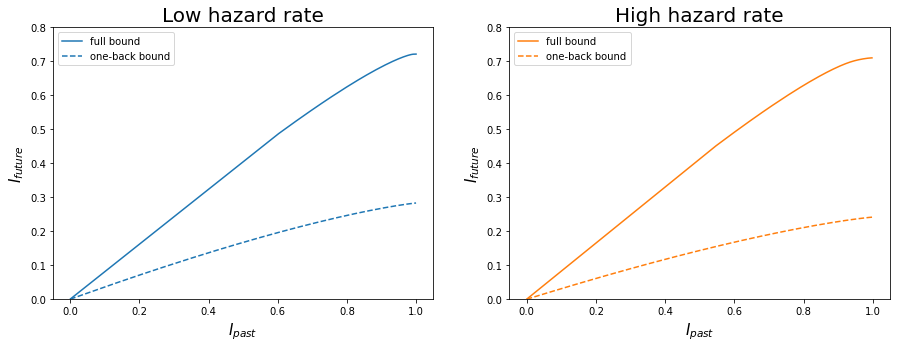

In [288]:
%%time
def get_windowed_bound(x,z,w,mb=50,nb=2000,p=8):
    '''
    Function that computes the information bottleneck bound between two discrete variables
    Input:
        - x: sequence of past events
        - z: sequence of future events
        - w: size of the window to be applied to x
        - mb: maximum value of the lagrange multiplier beta
        - nb: number of values of beta between 0 and mb to be run through the Blahaut-Arimoto algorithm
        - p: number of cores to use in the computation (to help with speed)
    Output:
        - 4 element tuple with a sequence of ipast and ifuture values corresponding to the information bottleneck for full and one back bounds
    '''
    # Get desired windowed x and corresponding z
    xw,zw = ut.get_windowed_x(x,z,w=w)
    
    # Compute the information bottleneck using EMBO for the window size w specified above
    ipw,ifw,betasw = EmpiricalBottleneck(xw,zw,minsize=True,processes=p,maxbeta=mb,numbeta=nb).get_empirical_bottleneck() 
    
    # Compute the information bottleneck using EMBO for the window size w specified above
    x1b,z1b = ut.get_windowed_x(x,z,w=1)
    ip1b,if1b,betas1b = EmpiricalBottleneck(x1b,z1b,minsize=True,processes=p,maxbeta=mb,numbeta=nb).get_empirical_bottleneck() 
   
    # Return informtion bottleneck
    return((ipw,ifw,ip1b,if1b))

# For speed, see if bottleneck has already been computed
try:
    # Low hazard full and 1-back bounds
    ipw_h1,ifw_h1,ipw_h1_1back,ifw_h1_1back = pickle.load(open('ipw_h1_bounds.pkl','rb'))
    
    # High hazard full and 1-back bounds
    ipw_h9,ifw_h9, ipw_h9_1back,ifw_h9_1back = pickle.load(open('ipw_h9_bounds.pkl','rb'))
    
except:
    # If no objects exist, compute full and one-back bounds for each hazard rate
    #Low hazard full and 1-back bounds
    ipw_h1,ifw_h1,ipw_h1_1back,ifw_h1_1back = get_windowed_bound(adat_trials['Bead'].loc[adat_trials['H'] == .01],
                                                                 adat_trials['Jar'].loc[adat_trials['H'] == .01],8)
    pickle.dump((ipw_h1,ifw_h1,ipw_h1_1back,ifw_h1_1back),open('ipw_h1_bounds.pkl','wb')) 
    
    #High hazard full and 1-back bounds
    ipw_h9,ifw_h9,ipw_h9_1back,ifw_h9_1back = get_windowed_bound(adat_trials['Bead'].loc[adat_trials['H'] == .99],
                                                                 adat_trials['Jar'].loc[adat_trials['H'] == .99],8)
    pickle.dump((ipw_h9,ifw_h9,ipw_h9_1back,ifw_h9_1back),open('ipw_h9_bounds.pkl','wb')) 
    
# Plot bounds for each hazard rate
plt.figure(1,(15,5))

# Low hazard rate
plt.subplot(1,2,1)
plt.plot(ipw_h1,ifw_h1,'-',color=cmap(0),label='full bound')
plt.plot(ipw_h1_1back,ifw_h1_1back,'--',color=cmap(0), label='one-back bound')
plt.ylim([0,.8])
plt.xlabel('$I_{past}$',size=15)
plt.ylabel('$I_{future}$',size=15)
plt.title('Low hazard rate',size=20)
plt.legend()

# High hazard rate
plt.subplot(1,2,2)
plt.plot(ipw_h9,ifw_h9,'-',color=cmap(1),label='full bound')
plt.plot(ipw_h9_1back,ifw_h9_1back,'--',color=cmap(1), label='one-back bound')
plt.ylim([0,.8])
plt.xlabel('$I_{past}$',size=15)
plt.ylabel('$I_{future}$',size=15)
plt.title('High hazard rate',size=20)
plt.legend()

CPU times: user 55.9 ms, sys: 2.56 ms, total: 58.5 ms
Wall time: 64.5 ms


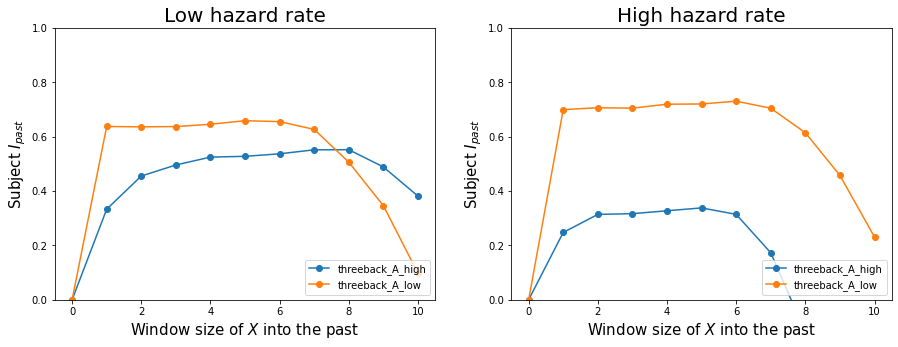

In [289]:
%%time
def get_windowed_mi_subs(sdat_all,nw):
    '''
    Function to compute windowed mutual information values for all subjects
    Input:
        - sdat_all: data frame with all of the subject tones, responses, and sources
        - nw: maximum window size to be considered
    Output:
        - Ipast for each window size and Ifuture
    '''
    # Create dictionaries to keep track of variables with subject IDs as the keys
    subs = pd.unique(sdat_all['Subject'])
    ip_sub = {}
    if_sub = {}
    # Loop through each subject and get their Ipast for windows up to nw and their ifuture
    for subi,sub in enumerate(subs):
        sdat = sdat_all[sdat_all['Subject'] == sub]                   # Get data from specific subject 
        ip_sub[sub] = get_windowed_mi(sdat['Bead'],sdat['Resp'],nw)    # compute Ipast using function defined above 
        if_sub[sub] = ut.mutual_inf_nsb(sdat['Resp'],sdat['Jar'],[2,2]) # compute Ifuture
    # Return dictionaries of ipast and ifuture values
    return(ip_sub,if_sub)

try:
    # Check if subject mutual information values have already been computed
    ips_sub_h1,if_sub_h1 = pickle.load(open('vickie_sim_mar9_ipf_sub_h1.pkl','rb')) #load windowed mutual information values for H=.01
    ips_sub_h9,if_sub_h9 = pickle.load(open('vickie_sim_mar9_ipf_sub_h9.pkl','rb')) #load windowed mutual information values for H=.99
except:
    # If not, compute them below
    # Low hazard rate
    ips_sub_h1,if_sub_h1 = get_windowed_mi_subs(adat_sim.loc[adat_sim['H'] == .01],10)
    #pickle.dump((ips_sub_h1,if_sub_h1),open('vickie_sim_mar9_ipf_sub_h1.pkl','wb'))
    
    # High hazard rate
    ips_sub_h9,if_sub_h9 = get_windowed_mi_subs(adat_sim.loc[adat_sim['H'] == .99],10)
    #pickle.dump((ips_sub_h9,if_sub_h9),open('vickie_sim_mar9_ipf_sub_h9.pkl','wb'))
    
# Plot ipast as a function of window size for each subject (different colors)
plt.figure(1,(15,5))
# Low hazard rate
plt.subplot(1,2,1)
for sub in pd.unique([key for key in ips_sub_h1.keys()]):
    plt.plot(np.arange(11),ips_sub_h1[sub],'-o',label = sub)
    plt.ylabel('Subject $I_{past}$',size=15)
    plt.xlabel('Window size of $X$ into the past',size=15)
    plt.title('Low hazard rate',size=20)
    plt.ylim([0,1])
    plt.legend(loc = 'lower right')

# high hazard rate
plt.subplot(1,2,2)
for sub in pd.unique([key for key in ips_sub_h9.keys()]):
    plt.plot(np.arange(11),ips_sub_h9[sub],'-o', label = sub)
    plt.ylabel('Subject $I_{past}$',size=15)
    plt.xlabel('Window size of $X$ into the past',size=15)
    plt.title('High hazard rate',size=20)
    plt.ylim([0,1])
    plt.legend(loc = 'lower right')

In [290]:
%%time
def get_bootstrapped_samples(dat,wips,nboot):
    '''
    Function to compute and return bootstrapped distributions of Ipast and Ifuture values for each subject
    Input:
        - dat: all subject data
        - wips: matrix of mutual information by widow size values for each subject
        - nboot: number of requested bootstrap iterations
    Output:
        - dictionaries of bootstrapped distributions of Ipast and Ifuture values
    '''
    # Get subject IDs and initialize dictionaries
    subs = pd.unique(dat['Subject'])
    ip_boot_mi = {}
    if_boot_mi = {}
    
    # Loop through each subject and get bootstrapped estimates
    for subi,sub in enumerate(subs):
        sdat = dat[dat['Subject'] == sub]   # Get subject data
        w = wips[sub].argmax()              # Get subject's maximum window size
        x = np.array(sdat['Bead'])           # Get tones, responses, and sources for the subject
        r = np.array(sdat['Resp'])
        z = np.array(sdat['Jar'])
        xw,rw = ut.get_windowed_x(x,r,w=(w+1)) # Window the tones and responses appropriately
        ip_boot_mi[sub] = np.zeros(nboot)      # Initialize arrays of mutual information values
        if_boot_mi[sub] = np.zeros(nboot)
        
        # Run bootstrap procedure
        for boot in np.arange(nboot):
            idx = np.random.choice(np.arange(len(xw)),size=len(xw),replace=True)    # Select random indicies with replacement
            ip_boot_mi[sub][boot] = ut.mutual_inf_nsb(xw[idx],rw[idx],[2**(w+1),2]) # Use indexed data to compute Ipast
            if_boot_mi[sub][boot] = ut.mutual_inf_nsb(r[idx],z[idx],[2,2])          # Use indexed data to compute Ifuture
    # Return dictionaries of Ipast and Ifuture distributions
    return(ip_boot_mi,if_boot_mi)

try:
    # Check to see if bootstrapped samples have already been computed
    ip_h1_boot, if_h1_boot = pickle.load(open('vickie_sim_mar9_ip_if_h1_boot.pkl','rb')) # Low hazard
    ip_h9_boot, if_h9_boot = pickle.load(open('vickie_sim_mar9_ip_if_h9_boot.pkl','rb')) # High hazard
except:
    # If not, compute and save below
    nboot = 1000 #number of bootstrapped samples
    #Low Hazard
    ip_h1_boot, if_h1_boot = get_bootstrapped_samples(adat_sim.loc[adat_sim['H'] == .01],ips_sub_h1,nboot)
    #pickle.dump((ip_h1_boot, if_h1_boot),open('vickie_sim_mar9_ip_if_h1_boot.pkl','wb'))
    
    # High hazard
    ip_h9_boot, if_h9_boot = get_bootstrapped_samples(adat_sim.loc[adat_sim['H'] == .99],ips_sub_h9,nboot)
    #pickle.dump((ip_h9_boot, if_h9_boot),open('vickie_sim_mar9_ip_if_h9_boot.pkl','wb'))

CPU times: user 1.12 ms, sys: 2.17 ms, total: 3.3 ms
Wall time: 3.58 ms


<Figure size 1080x360 with 0 Axes>

<AxesSubplot:>

<ErrorbarContainer object of 3 artists>

6

Text(108.0, 0.5, 'Subject Predictive Accuracy\n$I_{future}$')

Text(0.5, 24.0, 'Subject Information Complexity\n$I_{past}$')

Text(0.5, 1.0, 'Low Hazard Rate\nrho=-1.0,p=nan')

<AxesSubplot:>

<ErrorbarContainer object of 3 artists>

6

Text(0.5, 24.0, 'Subject Information Complexity\n$I_{past}$')

Text(0.5, 1.0, 'High Hazard Rate\nrho=1.0,p=nan')

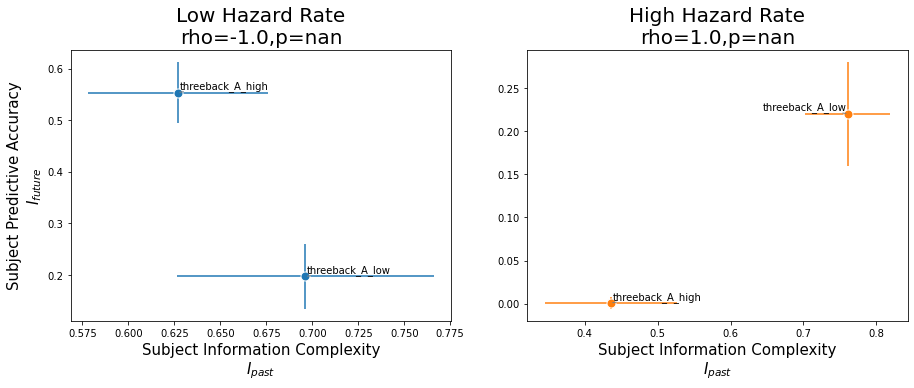

In [291]:
# Get mean Ipast/Ifuture values per subject
# Low hazard Ipast values and 95% confidence intervals
ip_mean_h1 = np.array([np.mean(ip_h1_boot[key]) for key in ip_h1_boot.keys()])
ip_95CI_h1 = np.array([np.std(ip_h1_boot[key])*1.96 for key in ip_h1_boot.keys()])

# Low hazard Ifuture values and 95% confidence intervals
if_mean_h1 = np.array([np.mean(if_h1_boot[key]) for key in if_h1_boot.keys()])
if_95CI_h1 = np.array([np.std(if_h1_boot[key])*1.96 for key in if_h1_boot.keys()])

# High hazard Ipast values and 95% confidence intervals
ip_mean_h9 = np.array([np.mean(ip_h9_boot[key]) for key in ip_h9_boot.keys()])
ip_95CI_h9 = np.array([np.std(ip_h9_boot[key])*1.96 for key in ip_h9_boot.keys()])

# High hazard Ifuture values and 95% confidence intervals
if_mean_h9 = np.array([np.mean(if_h9_boot[key]) for key in if_h9_boot.keys()])
if_95CI_h9 = np.array([np.std(if_h9_boot[key])*1.96 for key in if_h9_boot.keys()])

# Plot Ipast vs Ifuture in both hazard rate conditions
plt.figure(1,(15,5))
# Low hazard
plt.subplot(1,2,1)
r,p=spearmanr(ip_mean_h1,if_mean_h1)
plt.errorbar(ip_mean_h1,if_mean_h1,xerr=ip_95CI_h1,yerr = if_95CI_h1,
             marker='o',markersize=9,mec='white',color=cmap(0),ls='none')
texts = []
for i,sub in enumerate(ip_h1_boot.keys()): 
    texts.append(plt.text(ip_mean_h1[i],if_mean_h1[i],sub))
adjust_text(texts, arrowprops=dict(arrowstyle="-",color='grey'))
plt.ylabel('Subject Predictive Accuracy\n$I_{future}$',size=15)
plt.xlabel('Subject Information Complexity\n$I_{past}$',size=15)
plt.title('Low Hazard Rate\nrho={},p={}'.format(np.round(r,2),np.round(p,3)),size=20)
    
# High hazard
plt.subplot(1,2,2)
r,p=spearmanr(ip_mean_h9,if_mean_h9)
plt.errorbar(ip_mean_h9,if_mean_h9,xerr=ip_95CI_h9,yerr = if_95CI_h9,
             marker='o',markersize=9,mec='white',color=cmap(1),ls='none')
texts = []
for i,sub in enumerate(ip_h9_boot.keys()): 
    texts.append(plt.text(ip_mean_h9[i],if_mean_h9[i],sub))
adjust_text(texts, arrowprops=dict(arrowstyle="-",color='grey'))
plt.xlabel('Subject Information Complexity\n$I_{past}$',size=15)
plt.title('High Hazard Rate\nrho={},p={}'.format(np.round(r,2),np.round(p,3)),size=20)

<Figure size 1080x360 with 0 Axes>

<AxesSubplot:>

<ErrorbarContainer object of 3 artists>

6

Text(108.0, 0.5, 'Subject Predictive Accuracy\n$I_{future}$')

Text(0.5, 24.0, 'Subject Information Complexity\n$I_{past}$')

Text(0.5, 1.0, 'Low Hazard Rate')

<AxesSubplot:>

<ErrorbarContainer object of 3 artists>

6

Text(0.5, 24.0, 'Subject Information Complexity\n$I_{past}$')

Text(0.5, 1.0, 'High Hazard Rate')

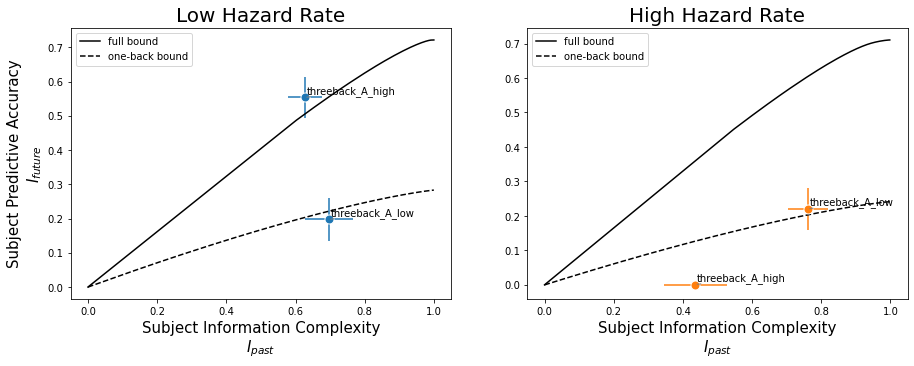

In [202]:
plt.figure(1,(15,5))
# Low hazard
plt.subplot(1,2,1)
r,p=spearmanr(ip_mean_h1,if_mean_h1)
plt.plot(ipw_h1,ifw_h1,'-k',label='full bound')
plt.plot(ipw_h1_1back,ifw_h1_1back,'--k',label='one-back bound')
plt.errorbar(ip_mean_h1,if_mean_h1,xerr=ip_95CI_h1,yerr = if_95CI_h1,
             marker='o',markersize=9,mec='white',color=cmap(0),ls='none')
texts = []
for i,sub in enumerate(ip_h1_boot.keys()): 
    texts.append(plt.text(ip_mean_h1[i],if_mean_h1[i],sub))
adjust_text(texts, arrowprops=dict(arrowstyle="-",color='grey'))
plt.ylabel('Subject Predictive Accuracy\n$I_{future}$',size=15)
plt.xlabel('Subject Information Complexity\n$I_{past}$',size=15)
plt.title('Low Hazard Rate',size=20)
plt.legend()
#plt.ylim([0,.8])
    
# High hazard
plt.subplot(1,2,2)
r,p=spearmanr(ip_mean_h9,if_mean_h9)
plt.plot(ipw_h9,ifw_h9,'-k',label='full bound')
plt.plot(ipw_h9_1back,ifw_h9_1back,'--k',label='one-back bound')
plt.errorbar(ip_mean_h9,if_mean_h9,xerr=ip_95CI_h9,yerr = if_95CI_h9,
             marker='o',markersize=9,mec='white',color=cmap(1),ls='none')
texts = []
for i,sub in enumerate(ip_h9_boot.keys()): 
    texts.append(plt.text(ip_mean_h9[i],if_mean_h9[i],sub))
adjust_text(texts, arrowprops=dict(arrowstyle="-",color='grey'))
plt.xlabel('Subject Information Complexity\n$I_{past}$',size=15)
plt.title('High Hazard Rate',size=20)
plt.legend()
#plt.ylim([0,.8])

<Figure size 1080x360 with 0 Axes>

<AxesSubplot:>

<ErrorbarContainer object of 3 artists>

6

Text(99.625, 0.5, 'Subject Distance from Full Bound')

Text(0.5, 24.0, 'Subject Information Complexity\n$I_{past}$')

Text(0.5, 1.0, 'Low Hazard Rate\nrho=-1.0,p=nan')

<AxesSubplot:>

<ErrorbarContainer object of 3 artists>

6

Text(0.5, 24.0, 'Subject Information Complexity\n$I_{past}$')

Text(0.5, 1.0, 'High Hazard Rate\nrho=-1.0,p=nan')

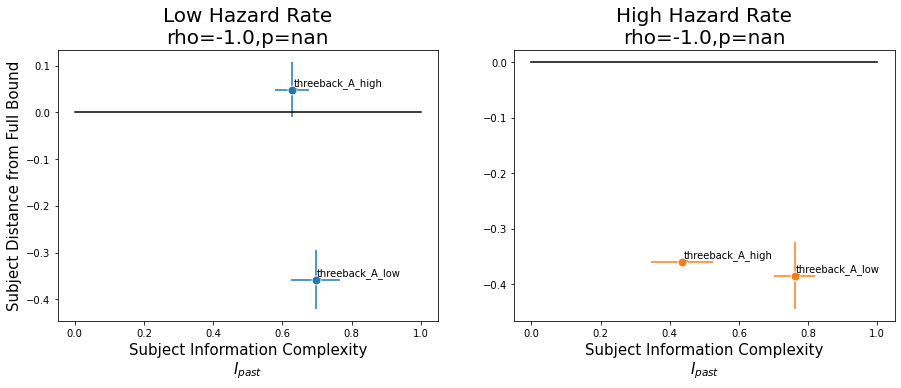

In [203]:
def deltaBound(ib_ipast,ib_ifuture,p_ipast,p_ifuture):
    ''' 
    Function to calculate vertical distance from the bound between an empirical IB and participant predictive info
    ib_ipast: ipast of empirical IB (x of convex hull)
    ib_ifuture: ifuture of empirical IB (y of convex hull)
    p_ipast: participant ipast (uncorrected)
    p_ifuture: participant ifuture (uncorrected)
    
    Returns participant ifuture minus the empirical bound (more negative = farther away from the bound)
    '''
    ind = np.argwhere(np.array(ib_ipast) > p_ipast)[0][0]
    slp = (ib_ifuture[ind]-ib_ifuture[ind-1])/(ib_ipast[ind]-ib_ipast[ind-1])
    intercept = ib_ifuture[ind]-(slp*ib_ipast[ind])
    #Return distance between participant Ifuture and interpolated bound
    return p_ifuture - ((p_ipast*slp)+intercept)

# Compute distance from the bound for each subject in each hazard rate condition
dbs1 = np.zeros(len(ip_mean_h1))
dbs9 = np.zeros(len(ip_mean_h9))
for i in np.arange(len(ip_mean_h1)):
    dbs1[i] = deltaBound(ipw_h1,ifw_h1,ip_mean_h1[i],if_mean_h1[i])
    dbs9[i] = deltaBound(ipw_h9,ifw_h9,ip_mean_h9[i],if_mean_h9[i])

# Plot distance from the bound for each hazard rate
plt.figure(1,(15,5))
# Low hazard
plt.subplot(1,2,1)
r,p=spearmanr(ip_mean_h1,dbs1)
plt.plot([0,1],[0,0],'-k',label='full bound')
plt.errorbar(ip_mean_h1,dbs1,xerr=ip_95CI_h1,yerr = if_95CI_h1,
             marker='o',markersize=9,mec='white',color=cmap(0),ls='none')
texts = []
for i,sub in enumerate(ip_h1_boot.keys()): 
    texts.append(plt.text(ip_mean_h1[i],dbs1[i],sub))
adjust_text(texts, arrowprops=dict(arrowstyle="-",color='grey'))
plt.ylabel('Subject Distance from Full Bound',size=15)
plt.xlabel('Subject Information Complexity\n$I_{past}$',size=15)
plt.title('Low Hazard Rate\nrho={},p={}'.format(np.round(r,2),np.round(p,3)),size=20)
#plt.xlim([0,1])
#plt.ylim([-.5,.12])
    
# High hazard
plt.subplot(1,2,2)
r,p=spearmanr(ip_mean_h9,dbs9)
plt.plot([0,1],[0,0],'-k',label='full bound')
plt.errorbar(ip_mean_h9,dbs9,xerr=ip_95CI_h9,yerr = if_95CI_h9,
             marker='o',markersize=9,mec='white',color=cmap(1),ls='none')
texts = []
for i,sub in enumerate(ip_h9_boot.keys()): 
    texts.append(plt.text(ip_mean_h9[i],dbs9[i],sub))
adjust_text(texts, arrowprops=dict(arrowstyle="-",color='grey'))
plt.xlabel('Subject Information Complexity\n$I_{past}$',size=15)
plt.title('High Hazard Rate\nrho={},p={}'.format(np.round(r,2),np.round(p,4)),size=20)
#plt.xlim([0,.8])
#plt.ylim([-.5,.12])

In [204]:
adat_sim = constant_table.assign(Subject = "threeback_A", 
                                           Rel_Hist = threeback_A_pred_table['rel_hist'],
                                           Resp = threeback_A_pred_table['pred'], Noise = noise,
                                           Confidence = threeback_A_confid_table['confid'])
adat_sim = twoback_B.copy()
adat_sim = adat_sim[adat_sim['Resp'] != -1]
#adat_sim['Resp'] = np.where(adat_sim['Resp']*1.0 == adat_sim['Noise'],1,0)
adat_sim['Correct'] = 1*(adat_sim['Jar'] == adat_sim['Resp'])

# Get mean correct responses per subject
adat_corr_sim_p = adat_sim[['Subject','H','Correct']].groupby(['Subject','H'],as_index=False).mean()
adat_corr_sim_p

adat_sim[['Subject','Correct']].groupby(['Subject'],as_index=False).mean()

,Subject,H,Correct
0,twoback_B,0.01,0.514019
1,twoback_B,0.99,0.491111


,Subject,Correct
0,twoback_B,0.505421


CPU times: user 1.38 s, sys: 21.8 ms, total: 1.4 s
Wall time: 1.4 s


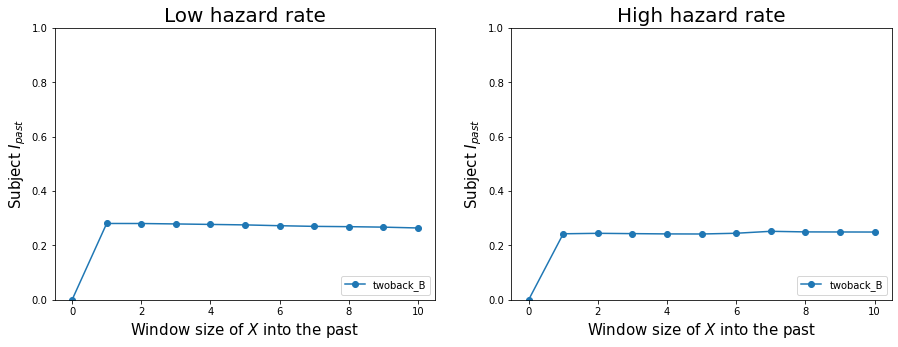

In [205]:
%%time
def get_windowed_mi_confid_subs(sdat_all,nw):
    '''
    Function to compute windowed mutual information values for all subjects
    Input:
        - sdat_all: data frame with all of the subject tones, responses, sources, correctness, confidence
        - nw: maximum window size to be considered
    Output:
        - Ipast for each window size and Ifuture
    '''
    # Create dictionaries to keep track of variables with subject IDs as the keys
    subs = pd.unique(sdat_all['Subject'])
    ip_sub = {}
    if_sub = {}
    # Loop through each subject and get their Ipast for windows up to nw and their ifuture
    for subi,sub in enumerate(subs):
        sdat = sdat_all[sdat_all['Subject'] == sub]                   # Get data from specific subject 
        ip_sub[sub] = get_windowed_mi(sdat['Jar'].iloc[0:].append(sdat['Jar'].iloc[:0]),sdat['Bead'],nw)    # compute Ipast using function defined above 
        if_sub[sub] = ut.mutual_inf_nsb(sdat['Resp'],sdat['Jar'],[2,2]) # compute Ifuture
    # Return dictionaries of ipast and ifuture values
    return(ip_sub,if_sub)

'''try:
    # Check if subject mutual information values have already been computed
    ips_sub_h1,if_sub_h1 = pickle.load(open('vickie_sim_mar10_ipf_sub_h1.pkl','rb')) #load windowed mutual information values for H=.01
    ips_sub_h9,if_sub_h9 = pickle.load(open('vickie_sim_mar10_ipf_sub_h9.pkl','rb')) #load windowed mutual information values for H=.99
except:'''
    # If not, compute them below
    # Low hazard rate
ips_sub_h1,if_sub_h1 = get_windowed_mi_confid_subs(adat_sim.loc[adat_sim['H'] == .01],10)
#pickle.dump((ips_sub_h1,if_sub_h1),open('vickie_sim_mar10_ipf_sub_h1.pkl','wb'))

# High hazard rate
ips_sub_h9,if_sub_h9 = get_windowed_mi_confid_subs(adat_sim.loc[adat_sim['H'] == .99],10)
#pickle.dump((ips_sub_h9,if_sub_h9),open('vickie_sim_mar10_ipf_sub_h9.pkl','wb'))
    
# Plot ipast as a function of window size for each subject (different colors)
plt.figure(1,(15,5))
# Low hazard rate
plt.subplot(1,2,1)
for sub in pd.unique([key for key in ips_sub_h1.keys()]):
    plt.plot(np.arange(11),ips_sub_h1[sub],'-o',label = sub)
    plt.ylabel('Subject $I_{past}$',size=15)
    plt.xlabel('Window size of $X$ into the past',size=15)
    plt.title('Low hazard rate',size=20)
    plt.ylim([0,1])
    plt.legend(loc = 'lower right')

# high hazard rate
plt.subplot(1,2,2)
for sub in pd.unique([key for key in ips_sub_h9.keys()]):
    plt.plot(np.arange(11),ips_sub_h9[sub],'-o', label = sub)
    plt.ylabel('Subject $I_{past}$',size=15)
    plt.xlabel('Window size of $X$ into the past',size=15)
    plt.title('High hazard rate',size=20)
    plt.ylim([0,1])
    plt.legend(loc = 'lower right')

In [154]:
adat_sim['Jar'].iloc[1:].append(adat_sim['Jar'].iloc[:1])

2       0
3       0
4       0
5       0
6       0
       ..
2396    1
2397    1
2398    1
2399    1
1       0
Name: Z, Length: 2399, dtype: int64

In [155]:
adat_sim['Resp'] 

1       1
2       1
3       1
4       1
5       1
       ..
2395    0
2396    0
2397    0
2398    0
2399    1
Name: Resp, Length: 2399, dtype: int64

In [144]:
for i in range(10): print(i)

0
1
2
3
4
5
6
7
8
9


In [ ]:
ip_sub[sub] = get_windowed_mi(sdat['Z'].iloc[0:].append(sdat['Z'].iloc[:0]) - 1,sdat['X'],nw)    # compute Ipast using function defined above 
if_sub[sub] = ut.mutual_inf_nsb(sdat['Resp'],sdat['Z'],[2,2]) # compute Ifuture